## 1. Problem Statement

Proyek ini bertujuan untuk membangun sistem rekomendasi anime yang menggunakan dua metode yaitu content-based filtering dan collaborative filtering. Proyek ini dilengkapi dengan dokumentasi setiap tahapan proses.

## 2. Import Library

In [ ]:
#import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score

Import library yang akan digunakan untuk pembuatan model

## 3. Data Understanding

**A. Memuat data**

In [ ]:
#import dataset
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

import dataset berupa dataset anime dan dataset rating yang diambil dari https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv

In [ ]:
#untuk melihat informasi type dari dataset
print("Anime dataset:")
print(anime.info())

print("\nRatings dataset:")
print(ratings.info())

Anime dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

Ratings dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


Dataset Anime memiliki baris 12294 dengan jumlah kolom 7 yang memiliki 3 type data yaitu integer, object, dan float. Dataset Rating memiliki jumlah baris 7813737 dengan jumlah kolom 3 yang memiliki jenis data integer.

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Menampilkan data 5 teratas dari dataset anime dan rating

In [ ]:
#Mengecek missing value atau data yang hilang di kolom
print("\n🔍 Cek Missing Value:")
print("Anime:")
print(anime.isnull().sum())
print("\nRatings:")
print(ratings.isnull().sum())


🔍 Cek Missing Value:
Anime:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Ratings:
user_id     0
anime_id    0
rating      0
dtype: int64


Terdapat nilai yang kosong dalam kolom genre, type, dan rating

In [ ]:
#mengecek data duplikat
print("\n🧹 Cek Duplikat:")
print(f"Duplikat di anime: {anime.duplicated().sum()} baris")
print(f"Duplikat di ratings: {ratings.duplicated().sum()} baris")


🧹 Cek Duplikat:
Duplikat di anime: 0 baris
Duplikat di ratings: 1 baris


Terdapat 1 baris duplikat yang harus dihapus di data preparation

**B. Exploratory Data Analysis**

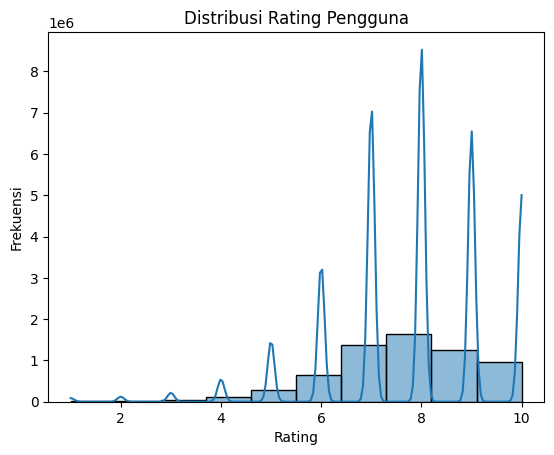

In [ ]:
# Distribusi Rating Pengguna
sns.histplot(ratings[ratings["rating"] != -1]["rating"], bins=10, kde=True)
plt.title("Distribusi Rating Pengguna")
plt.xlabel("Rating")
plt.ylabel("Frekuensi")
plt.show()

Frekuensi terbanyak pengguna memberikan rating 8 kemudian diikuti oleh rating 7,9, 10 dan seterusnya. Dapat diliat bahwa mayoritas pengguna memberikat rating diatas 6

<ipython-input-78-af132fd57507>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x="Count", y="Genre", palette="viridis")


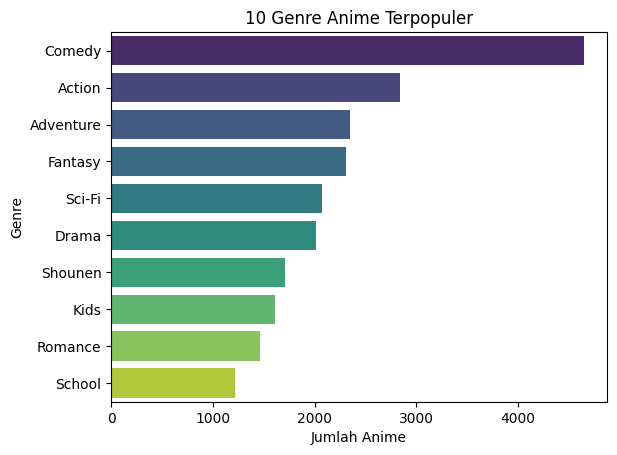

In [ ]:
# Genre yang Sering Muncul
anime["genre"] = anime["genre"].fillna("unknown")
genre_list = anime["genre"].dropna().str.split(", ").sum()
genre_counts = Counter(genre_list)

top_genres = pd.DataFrame(genre_counts.most_common(10), columns=["Genre", "Count"])
sns.barplot(data=top_genres, x="Count", y="Genre", palette="viridis")
plt.title("10 Genre Anime Terpopuler")
plt.xlabel("Jumlah Anime")
plt.ylabel("Genre")
plt.show()

Jumlah judul anime yang sering muncul memiliki genre comedy yang memiliki 4000 lebih judul. Kemudian dilanjutkan oleh genre action, adventure, dan seterusnya

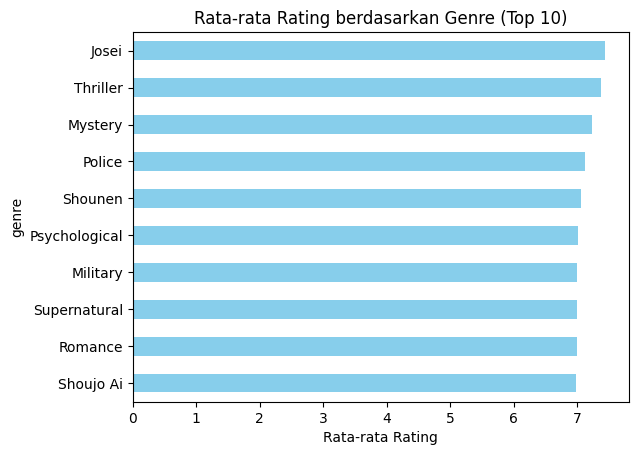

In [ ]:
# Rata-rata Rating Berdasarkan Genre
anime_genres_exploded = anime.dropna(subset=["genre"]).copy()
anime_genres_exploded["genre"] = anime_genres_exploded["genre"].str.split(", ")
anime_genres_exploded = anime_genres_exploded.explode("genre")

# Hitung rata-rata rating per genre
genre_rating = anime_genres_exploded.groupby("genre")["rating"].mean().sort_values(ascending=False).head(10)
genre_rating.plot(kind="barh", color="skyblue")
plt.xlabel("Rata-rata Rating")
plt.title("Rata-rata Rating berdasarkan Genre (Top 10)")
plt.gca().invert_yaxis()
plt.show()

Terdapat perbedaan perbandingan 10 genre berdasarkan judul anime yang sering muncul dan 10 genre berdasarkan rata-rat nilai rating. Pada perbandingan ini genre dengan nilai rating tertinggi dimiliki oleh genre josei diikuti thriller, mystery, dan lainnya dengan nilai diatas 7

## 4. Data Preparation

In [ ]:
# Data Cleaning
anime = anime.drop_duplicates()
ratings = ratings.drop_duplicates()
anime = anime.dropna()

Data cleaning terhadap data yang memiliki nilai kosong dan duplikat dengan penanganan menghapus data

In [ ]:
print("\n✅ Missing value setelah ditangani:")
print(anime.isnull().sum())


✅ Missing value setelah ditangani:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


Hasil dari data cleaning nilai kosong dan data sudah bersih dari nilai kosong

In [ ]:
print("\n🧹 Cek Duplikat setelah ditangani:")
print(f"Duplikat di anime: {anime.duplicated().sum()} baris")
print(f"Duplikat di ratings: {ratings.duplicated().sum()} baris")


🧹 Cek Duplikat setelah ditangani:
Duplikat di anime: 0 baris
Duplikat di ratings: 0 baris


Hasil dari drop duplikat

**Data Preparation Conten Based Filtering**

In [ ]:
# Mengecek genre yang kosong dengan mengganti unkown
anime['genre'] = anime['genre'].fillna('unknown')  # Replace NaN with 'unknown' instead of empty string

# Ambil hanya data yang memiliki genre dan nama yang unik
anime_cs = anime.dropna(subset=['genre', 'name']).drop_duplicates(subset='name').reset_index(drop=True)

# Ekstraksi Fitur Genre dengan TF-IDF (Text Vectorization)
tfidf = TfidfVectorizer(token_pattern=r'(\b\w+\b)', min_df=1)
tfidf_matrix = tfidf.fit_transform(anime_cs['genre'])



Data preparation pada conten based filtering dengan alur sebagai berikut :

1. Mengisi nilai kosong di kolom genre.
2. Membersihkan data dengan membuang baris kosong dan duplikat.
3. Mengekstraksi fitur genre menjadi vektor numerik dengan TF-IDF.



**Data Preparation Collaborativ Filtering**

In [ ]:
# Mengacak data rating untuk mengurasi data bias
ratings_shuffled = ratings.sample(frac=1, random_state=42).reset_index(drop=True)

- sample(frac=1): Mengacak seluruh baris data.
- random_state=42: Menjamin hasil acakan konsisten setiap kali dijalankan.
- reset_index(drop=True): Mengatur ulang indeks setelah diacak.

In [ ]:
# mengambil sampel data 3 juta sampel agar olah data lebih ringan
ratings_sample = ratings.sample(n=3000_000, random_state=42)

Mengambil 3 juta data acak dari dataset ratings.
Hal ini bertujuan agar proses komputasi lebih ringan dan cepat.

In [ ]:
#Menggabungkan data anime dan rating berdasrkan anime_id
anime_rating = pd.merge(ratings_sample, anime, on="anime_id").dropna()
anime_rating = anime_rating[anime_rating["rating_x"] > 0]

- merge(..., on="anime_id"): Menggabungkan data rating dan anime berdasarkan kolom anime_id.
- dropna(): Menghapus baris dengan nilai kosong.
- rating_x > 0: Mengambil hanya rating yang positif (lebih dari 0).

In [ ]:
# Encode user_id and anime_id
user_enc = LabelEncoder()
anime_enc = LabelEncoder()

# Fit ke seluruh ID unik dari dataset utama
user_enc.fit(anime_rating['user_id'])
anime_enc.fit(anime["anime_id"])  # Gunakan anime["anime_id"], bukan anime_rating

# Transform data training
anime_rating['user'] = user_enc.transform(anime_rating['user_id'])
anime_rating['anime'] = anime_enc.transform(anime_rating['anime_id'])
anime_rating['rating_x'] = anime_rating['rating_x'].values.astype(np.float32)

# Jumlah unik user dan anime
num_users = len(user_enc.classes_)
num_animes = len(anime_enc.classes_)

- LabelEncoder mengubah user_id dan anime_id dari string/integer unik ke bentuk numerik.
- Ini penting agar data bisa digunakan dalam model machine learning.
- Mengonversi rating ke tipe float32 untuk efisiensi memori.
- Menghitung jumlah pengguna dan anime yang unik setelah encoding.

In [ ]:
# Train-test split
X = anime_rating[['user', 'anime']].values
y = anime_rating['rating_x'].values/10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # mengambil nilai 80% dataset train dan 20% dataset validasi

# Pisahkan user dan anime ID
user_train = X_train[:, 0]
anime_train = X_train[:, 1]

user_test = X_test[:, 0]
anime_test = X_test[:, 1]

- X: Kombinasi user dan anime.
- y: Rating yang telah dinormalisasi (dibagi 10 agar skala antara 0–1).
- Memisahkan data: 80% untuk training, 20% untuk testing.
- stratify=y menjaga proporsi distribusi rating agar tetap sama di data train dan test.
- Memisahkan input X_train dan X_test menjadi kolom user dan anime untuk kemudahan pemrosesan selanjutnya (misalnya dalam model embedding).

## 5. Modeling

**A. Conten-Based Filtering**

In [ ]:
#Perhitungan Similaritas menggunakan Cosine Similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Buat mapping nama judul ke indeks pada anime_cs
indices = pd.Series(anime_cs.index, index=anime_cs['name'])

- tfidf_matrix: Matriks hasil ekstraksi genre dengan TF-IDF.
- linear_kernel(A, B): Digunakan untuk menghitung cosine similarity antar baris pada matriks.
- Output: Matriks 2D (misal 1000 x 1000) berisi skor kemiripan antar anime berdasarkan genre-nya.
- Membuat mapping antara nama anime dengan indeks dalam DataFrame anime_cs.
- Berguna untuk mengambil indeks saat mencari kemiripan berdasarkan nama anime.

In [ ]:
# Fungsi untuk memberikan rekomendasi berdasarkan genre
def content_based_recommendations(title, top_n=10):
    idx = indices[title] # Ambil indeks dari anime yang diminta
    sim_scores = list(enumerate(cosine_sim[idx])) # Ambil skor kemiripan dengan semua anime
    sim_scores[idx] = (idx, 0)  # hindari self-match

    # Urutkan skor kemiripan dari tinggi ke rendah
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top_n hasil teratas
    anime_indices = [i[0] for i in sim_scores[:top_n]]
    return anime_cs[['name', 'genre']].iloc[anime_indices]

- title: Judul anime yang dijadikan referensi.
- top_n: Jumlah rekomendasi yang ingin ditampilkan (default 10).
- cosine_sim[idx]: Mendapatkan semua skor similarity dari anime title ke anime lain.
- sim_scores[idx] = (idx, 0): Skor dengan dirinya sendiri di-nol-kan agar tidak direkomendasikan.
- sorted(..., reverse=True): Mengurutkan anime berdasarkan similarity tertinggi.
- anime_indices: Menyimpan indeks anime dengan similarity tertinggi.

**B. Collaborative Filtering (NeuMF)**

In [ ]:
# modeling NeuMF

def NeuMF(num_users, num_items, mf_dim=8, mlp_layers=[32, 16]):
    # Input
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # === GMF part (dengan regularisasi L2) ===
    user_embedding_gmf = Embedding(num_users, mf_dim, embeddings_regularizer=l2(1e-6))(user_input)
    item_embedding_gmf = Embedding(num_items, mf_dim, embeddings_regularizer=l2(1e-6))(item_input)
    gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

    # === MLP part (dengan Dropout dan L2 regularizer) ===
    user_embedding_mlp = Embedding(num_users, mlp_layers[0] // 2, embeddings_regularizer=l2(1e-6))(user_input)
    item_embedding_mlp = Embedding(num_items, mlp_layers[0] // 2, embeddings_regularizer=l2(1e-6))(item_input)
    mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

    for units in mlp_layers[1:]:
        mlp_vector = Dense(units, activation='relu', kernel_regularizer=l2(1e-6))(mlp_vector)
        mlp_vector = Dropout(0.3)(mlp_vector)  # dropout untuk cegah overfitting

    # === Gabung GMF dan MLP ===
    neuMF_vector = Concatenate()([gmf_vector, mlp_vector])
    output = Dense(1, activation='linear')(neuMF_vector)

    # Bangun model
    model = Model(inputs=[user_input, item_input], outputs=output)
    return model



Membangun model dengan NeuMF yang menggabungkan GMF (Generalized Matrix Factorization) dan MLP (Multi-Layer Perceptron)
- input layer
- Membuat embedding user dan item lalu mengalikan keduanya elemen-wise (seperti dot product).
- Embedding user dan item digabungkan (concatenate), lalu diproses lewat beberapa hidden layer.
- Dropout digunakan untuk mencegah overfitting.
- Menggabungkan GMF dan MLP dengan Output dari GMF dan MLP digabung jadi satu vektor.
- Layer terakhir menghasilkan nilai prediksi
- membangun model

In [ ]:
# mengompilasi model dengan fungsi optimizer, loss dan matric
model = NeuMF(num_users, num_animes)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Compilasi model dengan optimizer adam, loss function MSE, dan matrics MAE

In [ ]:
# Training data dengan 10x epoch
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit([user_train, anime_train], y_train,
                    epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stop])

Epoch 1/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0314 - mae: 0.1260 - val_loss: 0.0169 - val_mae: 0.0969
Epoch 2/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 137s 3ms/step - loss: 0.0172 - mae: 0.0977 - val_loss: 0.0165 - val_mae: 0.0953
Epoch 3/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0166 - mae: 0.0958 - val_loss: 0.0164 - val_mae: 0.0948
Epoch 4/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0165 - mae: 0.0953 - val_loss: 0.0164 - val_mae: 0.0946
Epoch 5/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - loss: 0.0165 - mae: 0.0951 - val_loss: 0.0164 - val_mae: 0.0945
Epoch 6/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.0164 - mae: 0.0950 - val_loss: 0.0164 - val_mae: 0.0952
Epoch 7/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 0.0165 - mae: 0.0950 - val_loss: 0.0163 - val_mae: 0.0943
Epoch 8/10
27376/27376 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.0164 - mae: 0.0950 - val_loss: 0.0163 - val_mae: 0.0945
Epoch 9/10
273

Training model dengan menggunakan fungsi early stop untuk menghentikan training model dengan 3 kali nilai tidak ada perubahan. Epoch yang digunakan 10x, batch size 64, dan validation split 0.1.

**Top N Rekomendasi**

In [ ]:
# Top 10 Rekomendasi berdasarkan judul
print("\nContent-Based Recommendations for 'Naruto':")
print(content_based_recommendations("Naruto"))


Content-Based Recommendations for 'Naruto':
                                                   name  \
486                            Boruto: Naruto the Movie   
615                                  Naruto: Shippuuden   
1103  Boruto: Naruto the Movie - Naruto ga Hokage ni...   
1343                                        Naruto x UT   
1472        Naruto: Shippuuden Movie 4 - The Lost Tower   
1573  Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...   
2458               Naruto Shippuuden: Sunny Side Battle   
2997  Naruto Soyokazeden Movie: Naruto to Mashin to ...   
7628                            Kyutai Panic Adventure!   
784          Naruto: Shippuuden Movie 6 - Road to Ninja   

                                                  genre  
486   Action, Comedy, Martial Arts, Shounen, Super P...  
615   Action, Comedy, Martial Arts, Shounen, Super P...  
1103  Action, Comedy, Martial Arts, Shounen, Super P...  
1343  Action, Comedy, Martial Arts, Shounen, Super P...  
1472  Action, C

Memanggil fungsi top 10 rekomendasi berdasarkan persamaan genre berdasarkan judul anime menggunakan conten based filtering

In [ ]:
## Top rekomendasi menggunakan NeuMF
def recommend_neumf(user_id, top_n=10):
    if user_id not in user_enc.classes_:
        return f"User ID {user_id} tidak ditemukan."

    # Encode user ID
    encoded_user = user_enc.transform([user_id])[0]

    # Dapatkan semua encoded anime ID yang dikenali model
    all_anime_encoded_ids = np.arange(len(anime_enc.classes_))

    # Buat array user input sebanyak jumlah anime
    user_input = np.full(len(all_anime_encoded_ids), encoded_user)

    # Prediksi rating
    preds = model.predict([user_input, all_anime_encoded_ids], verbose=0).flatten()

    # Ambil top N
    top_items = preds.argsort()[::-1][:top_n]

    # Mapping dari encoded ID → nama anime
    reverse_map = dict(zip(np.arange(len(anime_enc.classes_)),
                           anime[anime["anime_id"].isin(anime_enc.classes_)]["name"]))

    # Return hasil rekomendasi
    return [reverse_map[i] for i in top_items]


Fungsi ini memberikan top-N rekomendasi anime untuk user tertentu berdasarkan hasil prediksi dari model NeuMF.
- Memastikan user_id sudah ada di dataset yang dikenal model.
- Mengubah user_id asli menjadi ID yang dikenali model (integer).
- Mengambil semua anime ID dalam bentuk encoding.
- Menduplikasi ID user sebanyak jumlah anime untuk melakukan prediksi semua anime sekaligus.
- Model memprediksi skor/likelihood user menyukai setiap anime.
- Mengurutkan prediksi dari yang tertinggi dan mengambil top_n teratas.
- Membuat dictionary yang menghubungkan encoded anime ID ke nama asli anime.
- Mengembalikan list nama anime hasil rekomendasi.

In [ ]:
print("User ID asli:", user_enc.classes_[:5])

User ID asli: [2 3 5 7 8]


Melihat id asli dari top 5 untuk digunakan dalam pemanggilan fungsi berdasarkan user id

In [ ]:
# Memanggil fungsi recommend_neumf untuk user yang dikenali
user_id_terpilih = user_enc.classes_[1]  # Ganti index [0] sesuai kebutuhan

rekomendasi = recommend_neumf(user_id=user_id_terpilih, top_n=10)

# Jika hasilnya list, tampilkan vertikal
if isinstance(rekomendasi, list):
    print(f"Rekomendasi untuk User ID {user_id_terpilih}:\n")
    for i, nama in enumerate(rekomendasi, 1):
        print(f"{i}. {nama}")
else:
    # Kalau pesan error atau string
    print(rekomendasi)

Rekomendasi untuk User ID 3:

1. Inyouchuu Shoku
2. God Mazinger
3. Mahouka Koukou no Rettousei: Yoku Wakaru Mahouka!
4. Rinne no Lagrange Specials
5. Chime
6. PriPara Movie: Mi~nna no Akogare♪ Let&#039;s Go☆Prix Paris
7. Fantasia
8. Panpaka Pants
9. Uchuu Kaizoku Captain Harlock
10. Nekketsu Tantei Jimusho


memanggil user id dengan menggunakan index 1, yang mana index dihitung dari 0 sehingga user id yang digunakan yaitu user id 3. Hasilnya didapatkan 10 rekomendasi judul anime yang disukai user id 3.

In [ ]:
# === SIMULASI PENGGUNA: PERBANDINGAN 2 MODEL ===
def simulate_recommendation(user_id, liked_title):
    print(f"\n📌 Rekomendasi berdasarkan genre mirip dengan '{liked_title}':")
    print(content_based_recommendations(liked_title))

    print(f"\n📌 Rekomendasi berdasarkan riwayat user {user_id} (NeuMF):")
    recs = recommend_neumf(user_id)
    for i, name in enumerate(recs, 1):
        print(f"{i}. {name}")

In [ ]:
# menampilkan data rekomendasi dari dua model
simulate_recommendation(user_id=3, liked_title="Naruto")


📌 Rekomendasi berdasarkan genre mirip dengan 'Naruto':
                                                   name  \
486                            Boruto: Naruto the Movie   
615                                  Naruto: Shippuuden   
1103  Boruto: Naruto the Movie - Naruto ga Hokage ni...   
1343                                        Naruto x UT   
1472        Naruto: Shippuuden Movie 4 - The Lost Tower   
1573  Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...   
2458               Naruto Shippuuden: Sunny Side Battle   
2997  Naruto Soyokazeden Movie: Naruto to Mashin to ...   
7628                            Kyutai Panic Adventure!   
784          Naruto: Shippuuden Movie 6 - Road to Ninja   

                                                  genre  
486   Action, Comedy, Martial Arts, Shounen, Super P...  
615   Action, Comedy, Martial Arts, Shounen, Super P...  
1103  Action, Comedy, Martial Arts, Shounen, Super P...  
1343  Action, Comedy, Martial Arts, Shounen, Super P...  
1472

Hasil perbandingan Top N menggunakan 2 model Content Based Filtering dan Collaborative Filttering dengan NeuMF.

## Evalusasi

**Evaluasi Content-Based Filtering**

In [ ]:
# Cosine Similirity
# menggunakan anime_cs yang sesuai
indices = pd.Series(anime_cs.index, index=anime_cs['name']).drop_duplicates()

def evaluate_content_based():
    sample_titles = anime_cs['name'].sample(100, random_state=42)
    score_list = []
    for title in sample_titles:
        idx = indices[title]
        sims = cosine_sim[idx]
        sims[idx] = 0  # agar tidak menghitung kemiripan dengan dirinya sendiri
        top_sim = np.max(sims)
        score_list.append(top_sim)
    avg_score = np.mean(score_list)
    print(f"Rata-rata similarity tertinggi dari 100 sampel: {avg_score:.4f}")
    return score_list

# Jalankan evaluasi
score_list = evaluate_content_based()

Rata-rata similarity tertinggi dari 100 sampel: 0.9805


Evaluasi model conten based filtering menggunakan nilai cosine similarity dengan jumlah sampel 100 yang menghasilkan nilai similarity 0.9805 yang menandakan model tersebut bisa dikatakan bagus

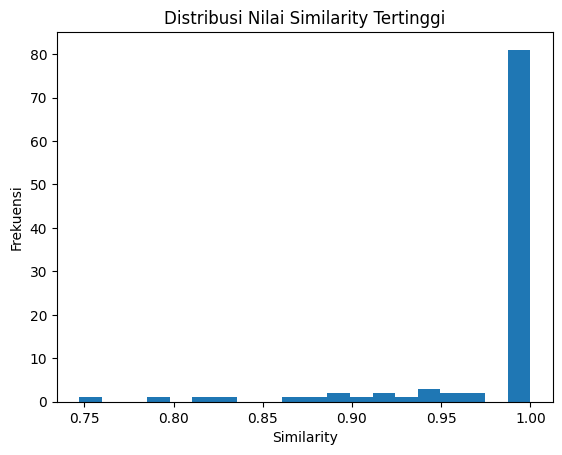

In [ ]:
#plot distribusi nilai similarity tertinggi dari 100 sampel

plt.hist(score_list, bins=20)
plt.title('Distribusi Nilai Similarity Tertinggi')
plt.xlabel('Similarity')
plt.ylabel('Frekuensi')
plt.show()


Nilai dari 100 sampel yang mendekati nilai 10 berjumlah sekitar 80 frekuensi sedangkan nilai similarity terendan di 0.75

In [ ]:
# Anggap user_id dan anime_id belum diencoding
liked_threshold = 7

# Buat dict {user_id: set of liked anime_id}
user_likes = (
    ratings[ratings['rating'] >= liked_threshold]
    .groupby('user_id')['anime_id']
    .apply(set)
    .to_dict()
)

Threshold ini digunakan untuk menentukan apakah sebuah anime disukai. Artinya: rating ≥ 7 dianggap disukai. Kemudian membuat dictionary baru

In [ ]:
# Input content recomendation

def get_content_recommendations(user_id, top_n=10):
    # Ambil anime yang disukai user
    liked_animes = anime_rating[(anime_rating["user_id"] == user_id) & (anime_rating["rating_x"] >= 8)]["anime_id"]

    # Jika user belum punya rating yang layak
    if len(liked_animes) == 0:
        return []

    # Vektor fitur untuk semua anime
    liked_indices = anime[anime["anime_id"].isin(liked_animes)].index
    liked_vectors = tfidf_matrix[liked_indices]

    # Hitung skor cosine similarity ke semua anime
    sim_scores = cosine_similarity(liked_vectors, tfidf_matrix)

    # Rata-rata similarity terhadap anime yang disukai
    mean_scores = sim_scores.mean(axis=0)

    # Urutkan dan ambil top_n
    top_indices = mean_scores.argsort()[::-1]

    # Buang anime yang sudah dilike sebelumnya
    top_recommendations = []
    for idx in top_indices:
        anime_id = anime.iloc[idx]["anime_id"]
        if anime_id not in liked_animes:
            top_recommendations.append(anime_id)
        if len(top_recommendations) >= top_n:
            break

    return top_recommendations


Memanggil fungsi get rekomendasi yaitu Memberikan rekomendasi anime berdasarkan kemiripan konten (TF-IDF fitur) terhadap anime yang disukai user.

In [ ]:
# Evaluasi dengan precision, recall, dan f1 score pada conten based filtering
def evaluate_content_based(top_n=10, sample_size=100):
    user_ids = list(user_likes.keys())[:sample_size]
    precisions, recalls, f1_scores = [], [], []

    # Buat mapping dari anime_id asli ke encoded index
    id_to_encoded = dict(zip(anime["anime_id"], anime_enc.transform(anime["anime_id"])))

    for user_id in user_ids:
        liked_animes = user_likes.get(user_id, set())

        # Ambil rekomendasi dari content-based (hasilnya bisa nama atau anime_id asli)
        recommended = get_content_recommendations(user_id, top_n=top_n)

        if not recommended:
            continue

        # Cek apakah hasil berupa nama (string) atau ID (int)
        if isinstance(recommended[0], str):
            name_to_id = dict(zip(anime["name"], anime["anime_id"]))
            recommended_ids = [name_to_id.get(name) for name in recommended if name in name_to_id]
        else:
            recommended_ids = recommended

        # Ubah ID asli ke encoded index dengan validasi None
        recommended_encoded = [
            id_to_encoded.get(anime_id)
            for anime_id in recommended_ids
            if anime_id in id_to_encoded and id_to_encoded.get(anime_id) is not None
        ]

        if not recommended_encoded:
            continue

        recommended_set = set(recommended_encoded)
        tp = len(recommended_set & liked_animes)
        precision = tp / len(recommended_set) if recommended_set else 0
        recall = tp / len(liked_animes) if liked_animes else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    print(f"Evaluasi Content-Based Filtering (top-{top_n}):")
    print(f"Average Precision: {np.mean(precisions):.4f}")
    print(f"Average Recall:    {np.mean(recalls):.4f}")
    print(f"Average F1 Score:  {np.mean(f1_scores):.4f}")


In [ ]:
evaluate_content_based(top_n=10, sample_size=100)

Evaluasi Content-Based Filtering (top-10):
Average Precision: 0.0033
Average Recall:    0.0004
Average F1 Score:  0.0007


Menghitung metrik evaluasi (precision, recall, dan F1-score) untuk sistem rekomendasi berbasis konten menggunakan data yang tersedia dari user_likes. Hasil dari evaluasinya yaitu Average Precision: 0.0033, Average Recall: 0.0004, dan Average F1 Score: 0.0007.

**Evaluasi Collaborative Filtering**

In [ ]:
# Prediksi (dalam skala 0–1)
y_pred = model.predict([user_test, anime_test])

# Kembalikan ke skala asli (1–10)
y_pred = np.clip(y_pred, 0, 1) * 10
y_true = y_test * 10  # skala rating asli

# Evaluasi
loss, mae = model.evaluate([user_test, anime_test], y_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"NeuMF Evaluation:\nMAE: {mae * 10:.4f}, RMSE: {rmse:.4f}")


15209/15209 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
15209/15209 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.0161 - mae: 0.0943
NeuMF Evaluation:
MAE: 0.9424, RMSE: 1.2328


Mengevaluasi model NeuMF dengan nilai MAE dan RMSE yang menghasilkan nilai MAE 0.9424 dan RMSE 1.2328

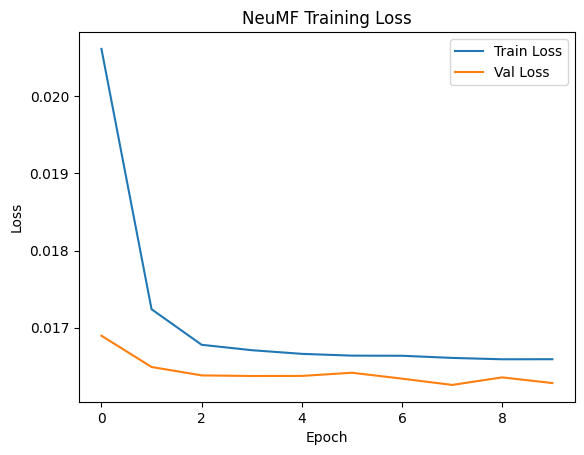

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NeuMF Training Loss')
plt.legend()
plt.show()

Ploting train loss dan vall loss grafik menurun di epoch 1-3, kemudian relative turun hingga epoch 10